In [1]:
import sys
sys.path.append("../exp/")

from models import get_pipe
import BPt as bp
import numpy as np
import os
from neurotools.plotting import plot

/home/sage/anaconda3/envs/bpt/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# Load in dataset
data = bp.read_pickle('../data/dataset.pkl')

# Let's replace the loaded consolidated data files
data = bp.Dataset(data['target'])
data = data.set_role(scope=list(data), role='target')
data.shape

# Add data files
files = {'curv': '../data/abcd_structural/curv/*.npy',
         'sulc': '../data/abcd_structural/sulc/*.npy',
         'thick': '../data/abcd_structural/thick/*.npy',
         'myelin': '../data/abcd_structural/myelin/*.npy'}
data = data.add_data_files(files, file_to_subject='auto')

# Drop all data w/ all missing target
data = data.drop_subjects_by_nan('target', threshold=.99)

data.get_cols('data'), data.shape

Setting NaN threshold to: 44.55
Dropped 597 Rows


(['curv', 'myelin', 'sulc', 'thick'], (9432, 49))

In [3]:
# Set problem spec
ps = bp.ProblemSpec(target='sex_at_birth',
                    n_jobs=8,
                    random_state=5)

# Helper function around eval
def run_eval(pipe):
    
    # Run evaluate
    return bp.evaluate(pipeline=pipe,
                       dataset=data,
                       problem_spec=ps,
                       subjects='all',
                       mute_warnings=True,
                       cv=2)

## Base Elastic-Net

In [4]:
# Get pipelines
pipe = get_pipe('elastic', 'random_50_0')

# Run evaluate
results = run_eval(pipe)

Get pipeline with: elastic random_50_0 None
cache_fit_loc: None
Predictions will still be made for any subjects with missing values in any validation folds.
Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 4 features).
Evaluating 9432 total data points.


Folds:   0%|          | 0/2 [00:00<?, ?it/s]


Training Set: (4712, 4) (skipped 4 NaN targets)
Validation Set: (4708, 4) (skipped 8 NaN targets)
Fit fold in 0.8 seconds.
explained_variance: 0.0411
neg_mean_squared_error: -21.94

Training Set: (4708, 4) (skipped 8 NaN targets)
Validation Set: (4712, 4) (skipped 4 NaN targets)
Fit fold in 0.9 seconds.
explained_variance: 0.0413
neg_mean_squared_error: -21.10



In [5]:
# We can get the back projected feature importances w/ experimental function get_inverse_fis
inverse_fis = results.get_inverse_fis()

In [6]:
# Stored per fold, in pandas Series
len(inverse_fis), inverse_fis[0]

(2,
 curv      [0.091007724, -0.0, -0.0, -0.20804065, 0.00823...
 myelin    [0.0, -0.008152577, -0.008152577, 0.0, -0.0, -...
 sulc      [0.55122715, -0.0991654, -0.0991654, 0.0, 0.04...
 thick     [-0.0, -0.0, -0.0, -0.39402473, 0.47730905, 0....
 dtype: object)

In [7]:
# First fold, inverse shape
inverse_fis[0][0].shape

(64984,)

In [8]:
# We can average across each fold like this
avg_inverse = np.mean(np.array(inverse_fis), axis=0)
avg_inverse.shape, avg_inverse[0].shape

((4,), (64984,))

In [9]:
def plot_avg(inverse_fis):
    
    # Get average
    avg_inverse = np.mean(np.array(inverse_fis), axis=0)
    
    # Set colorbar max and min same across each
    # m = np.max(np.abs(avg_inverse))
    # m *= 1.05
    
    # Use mean val as threshold
    thresh = np.mean(np.mean(np.abs(avg_inverse)))
    
    # Plot average features for each modality seperate
    for name, vals in zip(inverse_fis[0].index, avg_inverse):
        plot(vals, threshold=thresh, title=name)

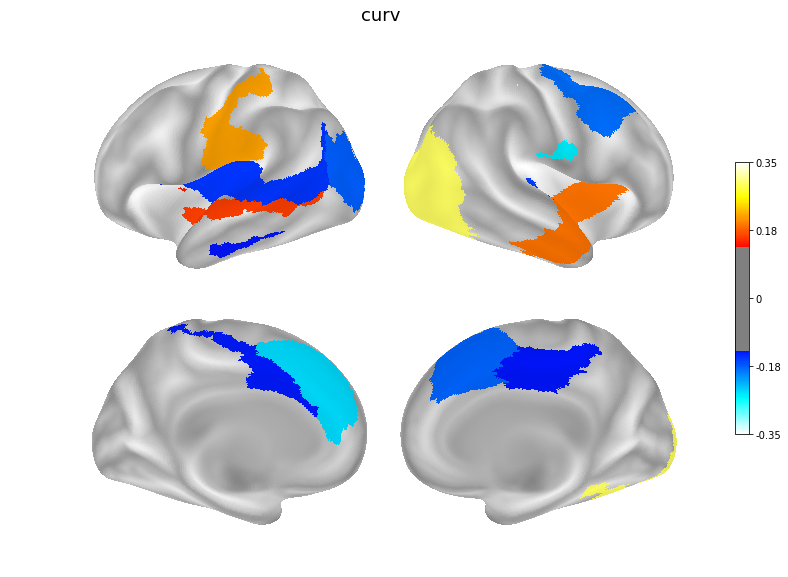

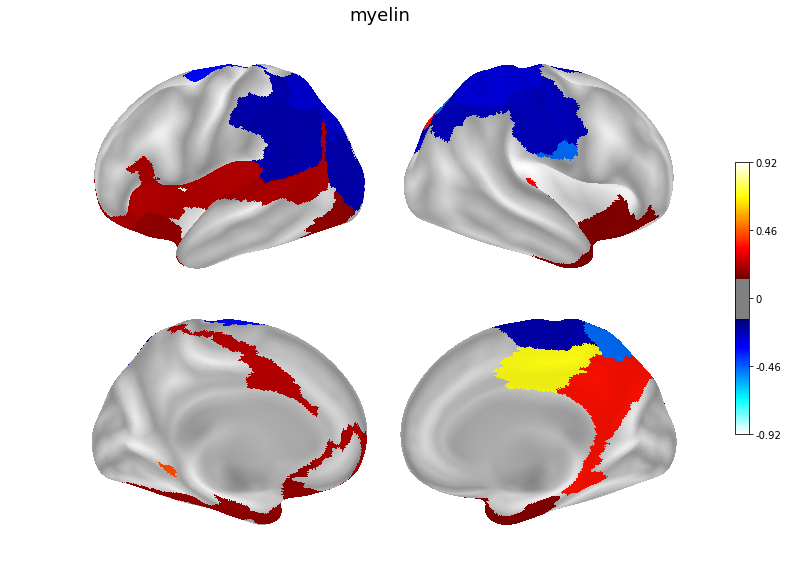

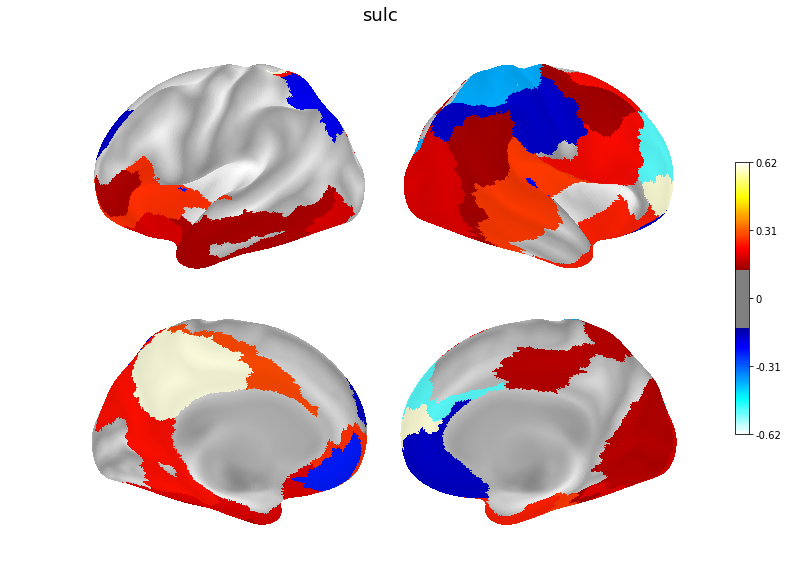

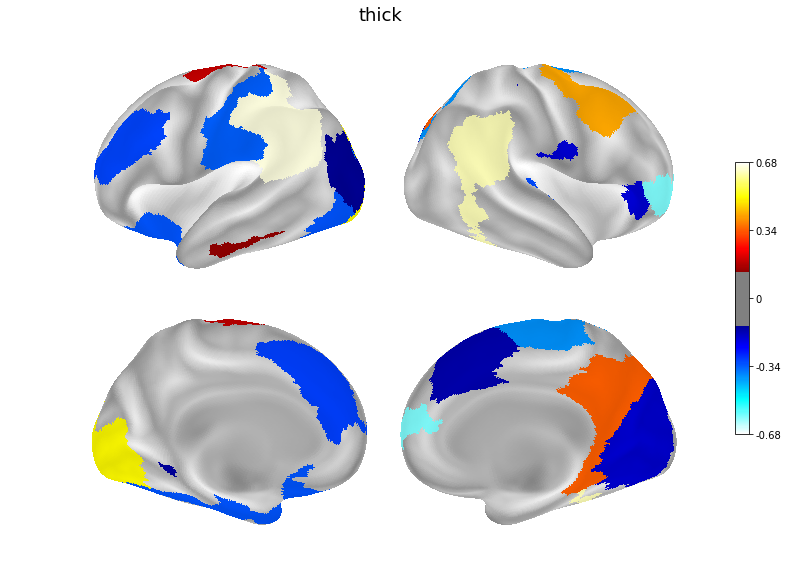

In [10]:
plot_avg(inverse_fis)

## Base - LGBM

Get pipeline with: lgbm random_50_0 None
cache_fit_loc: None
Predictions will still be made for any subjects with missing values in any validation folds.
Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 4 features).
Evaluating 9432 total data points.


Folds:   0%|          | 0/2 [00:00<?, ?it/s]


Training Set: (4712, 4) (skipped 4 NaN targets)
Validation Set: (4708, 4) (skipped 8 NaN targets)
Fit fold in 0.9 seconds.
explained_variance: 0.0444
neg_mean_squared_error: -29.40

Training Set: (4708, 4) (skipped 8 NaN targets)
Validation Set: (4712, 4) (skipped 4 NaN targets)
Fit fold in 0.9 seconds.
explained_variance: 0.0523
neg_mean_squared_error: -23.36



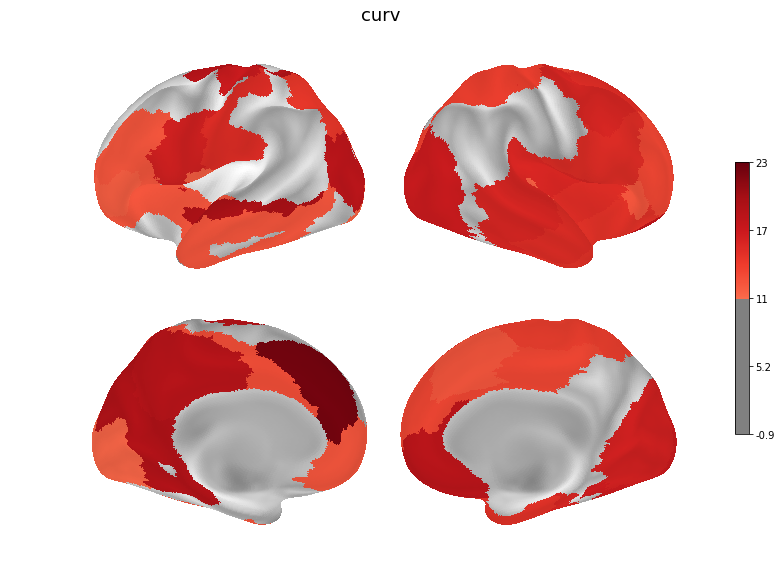

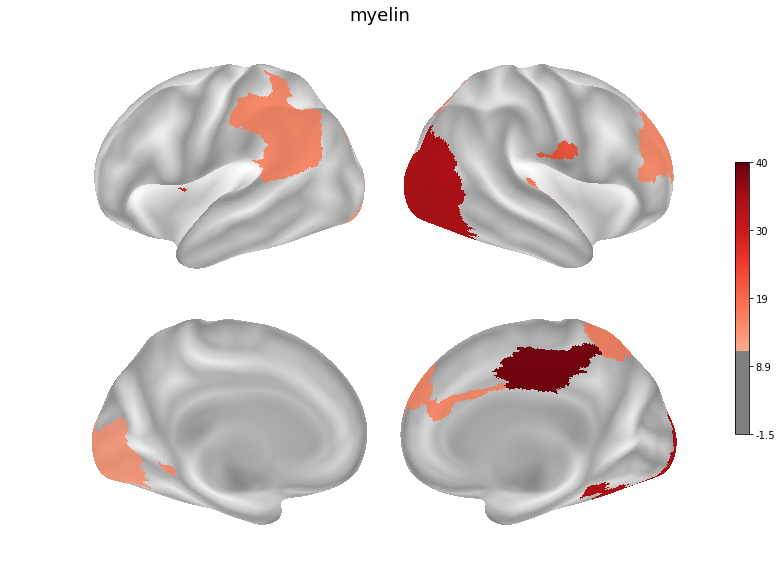

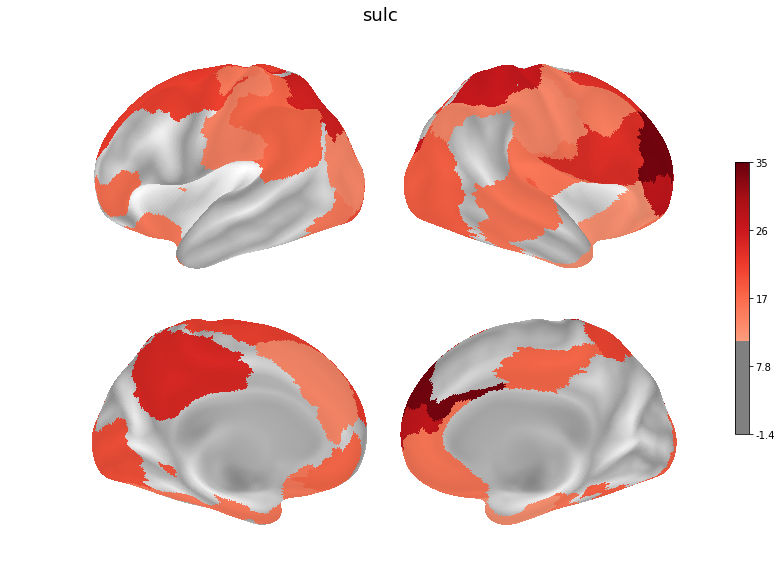

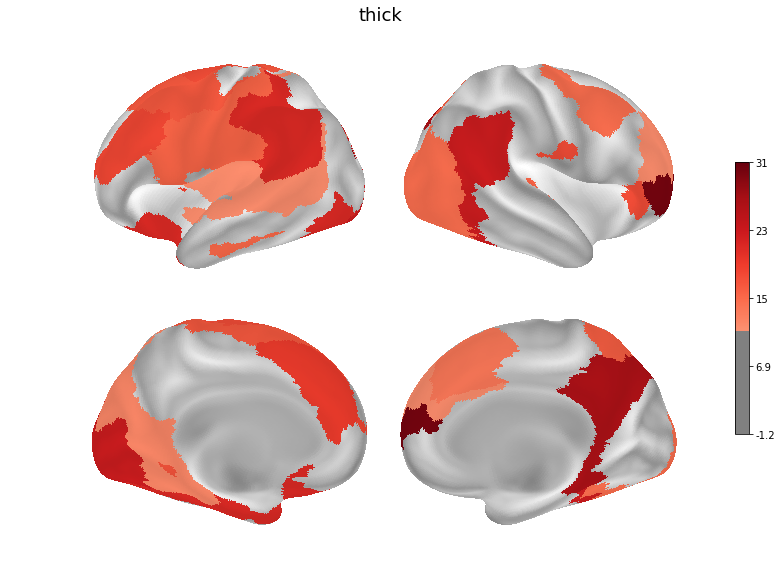

In [11]:
# Get pipelines
pipe = get_pipe('lgbm', 'random_50_0')

# Run evaluate
results = run_eval(pipe)

inverse_fis = results.get_inverse_fis()
plot_avg(inverse_fis)

## What about a voting ensemble of Elastic-Net ?

In this case, what goes on behind the scenes is that the coef_ from each of the base models are averaged. In a more detailed sense, when get inverse fis is called, the coef_ from each base ensemble are first back projected to the original space, then they are averaged. Even though each base estimator has 100 coef_, it would be wrong to average them in that space since each coef_ refers to a different parcellation, it is therefore neccisary to average only after back projection. This is taken care of internally just by using `Ensemble(obj="loader voting")` whereas if we used the base object `Ensemble(obj="voting")`, calling get_inverse_fis would just trigger an error, and if we looked at the resulting coef_, they would just be the averaged 100 coef_ from the different random parcellations, i.e., meaningless or even potentially misleading. Therefore since we have nested loaders in the ensemble, we want to make sure to use the loader voting object.

In [ ]:
# Get pipeline
pipe = get_pipe('elastic', 'voted_random_100_10_1')

# Run evaluate
results = run_eval(pipe)

# Get inverse and plot
inverse_fis = results.get_inverse_fis()
plot_avg(inverse_fis)

This method is also dynamic enough to support averaging across parcellations of different sizes / with lgbm feature importances instead of coef_

In [ ]:
# Get pipeline
pipe = get_pipe('lgbm', 'voted_random_100-1000_3_0')

# Run evaluate
results = run_eval(pipe)

results.get_inverse_fis()
plot_avg(inverse_fis)

## SVM / Permutation Feature Importance

For the Elastic-Net and LGBM, they both have default already calculated feature importances which we can back project and plot right away. For the SVM based pipelines though, this isn't possible. Instead we need to calculate feature importances in another way, in this example we will use permutation based feature importances.

In [ ]:
# Get pipelines
pipe = get_pipe('svm', 'random_50_0')

# Run evaluate
results = run_eval(pipe)

In [ ]:
# Calculate p_fis
p_fis = results.permutation_importance(dataset=data,
                                       n_repeats=10,
                                       just_model=True,
                                       nested_model=True,
                                       return_as='dfs',
                                       n_jobs=-1)

In [ ]:
# From permutation fis can get inverse by passing alongs means
inverse_fis = results.get_inverse_fis(p_fis['importances_mean'])

# Plot
plot_avg(inverse_fis)

## SVM based voting ensemble

So the way we had the voting ensemble feature importances set up before, we took the average of each once back projected. Now what about when we have an ensemble of SVM classifiers? In this case we need to do the permutation feature importances again, but we want to ensure that the features being permuted are the fully transformed features. Let's get an example going before getting into more details...

In [ ]:
# Get pipeline
pipe = get_pipe('svm', 'voted_random_100_2_0')

# Run evaluate
results = run_eval(pipe)

So what happens internally when we are going to call `permutation_importance` is the following internal function is called to setup the proper X_val, and locate the proper sub estimator for each fold. In this case we want just just_model and nested_model to be True.

In [ ]:
# Get base X and y from dataset
X, y = data.get_Xy(results.ps)

# Call this internal methods for fold 0
estimator, X_val, y_val, feat_names =\
                results._get_val_fold_Xy(results.estimators[0],
                                         X_df=X, y_df=y,
                                         fold=0,
                                         just_model=True,
                                         nested_model=True)

Looking at X_val, we notice the shape might look a little funny - but we can confirm that it lines up with the feat names.

In [ ]:
X_val.shape, len(feat_names)

So what's going on here? First note that we have a random ensemble with two random parcellations each with size 100, and we also have 4 modalities. So that means after being loaded and transformed, each parcellation will yield  400 features, then two sub SVM models with front-end feature selection will be fed in 400 features each. So why do we have 598 features here? We can get a better idea of what these features represent if we look at the feat names

In [ ]:
feat_names[300:310], feat_names[-1]

So two things are going on here, the first you'll note is that there are some features missing. That is because these feat names and X_val represent the transformed data after any features that were selected to be removed by  the feature selection step were already removed. The other piece you'll note is the 0_ appended to the features above, and the '1_' appended to the last feature we printed. That is to say the features and X_val represent the concatenated fully transformed output from each of the two sub-svm models.

Basically, this is exactly what we want, as we need all avaliable features to be already present (i.e., not waiting to be transformed) when we pass them to the function responsible for calculating the permutation based feature importances. Essentially the last step that happens internally, that we don't need to worry about, is the 'predict' function for BPtVotingEstimator is designed to automatically detect this alternative output, we can confirm that here:

In [ ]:
estimator

In [ ]:
# The estimator despite still containing the nested Loaders
# is designed to still be able to accept the already transformed
# by its own nested Loader's input to its predict function
estimator.predict(X_val).shape

Now that we know whats going on behind the scenes, we with BPt can just do the same exact thing as before, and it will take care of the details!

In [ ]:
# Calculate p_fis
p_fis = results.permutation_importance(dataset=data,
                                       n_repeats=10,
                                       just_model=True,
                                       nested_model=True,
                                       return_as='dfs',
                                       n_jobs=-1)

# Get inverse, same as before
inverse_fis = results.get_inverse_fis(p_fis['importances_mean'])

# Plot
plot_avg(inverse_fis)

## Stacked Ensembles - Elastic-Net

Okay, now what about with a stacking based ensemble? Well, we can do something simmilar to voting, but instead of just taking the mean of the existing feature importances, we want to take a weighted average according to the feature importances of the stacking regressor itself. Though note that in order for this to work we have to make a simplification, that being that we throw away information on magnitude, and instead consider only the absolute average values according to the absolute weights of the stacker. 

In [ ]:
# Get pipeline
pipe = get_pipe('elastic', 'stacked_random_100_3_1')

# Run evaluate
results = run_eval(pipe)

In [ ]:
results.get_inverse_fis()
plot_avg(inverse_fis)

We can also in the same manner as before consider the generation and plotting of permutation based feature importances, e.g., in the case of using an SVM based classifier instead of elastic-net

In [ ]:
# Calculate p_fis
p_fis = results.permutation_importance(dataset=data,
                                       n_repeats=10,
                                       just_model=True,
                                       nested_model=True,
                                       return_as='dfs',
                                       n_jobs=-1)

# Get inverse, same as before
inverse_fis = results.get_inverse_fis(p_fis['importances_mean'])

# Plot
plot_avg(inverse_fis)